In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline 

# Reading The Data  

In [2]:
train=pd.read_csv('Datasets\\train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Visualization 

<AxesSubplot:>

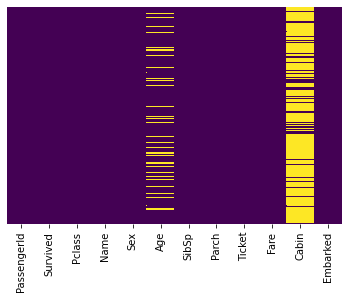

In [3]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<AxesSubplot:xlabel='Survived', ylabel='count'>

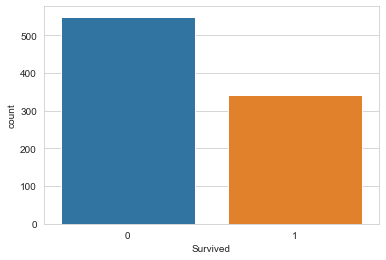

In [4]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

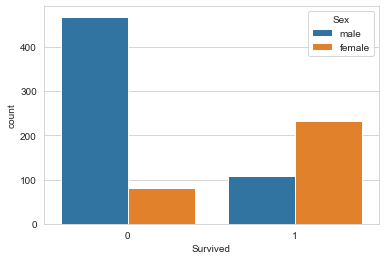

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

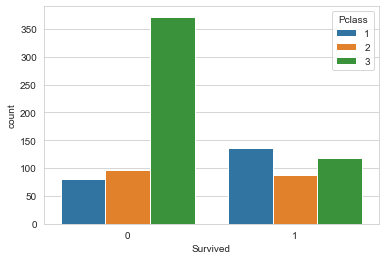

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train)

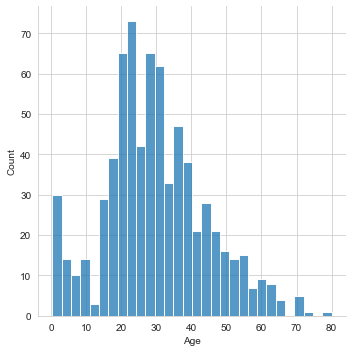

In [7]:
sns.displot(train['Age'].dropna(),kde=False,bins=30)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

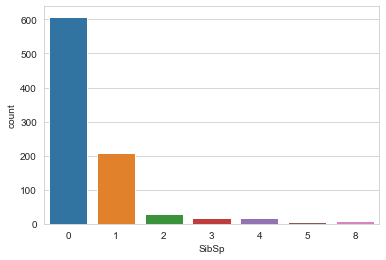

In [8]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

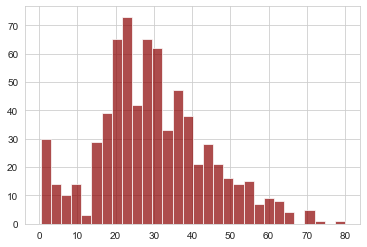

In [9]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

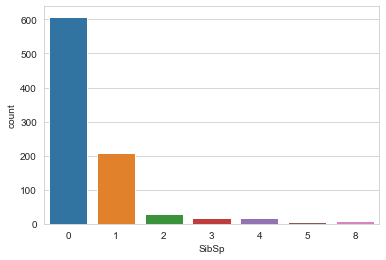

In [10]:
sns.countplot(x='SibSp',data=train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


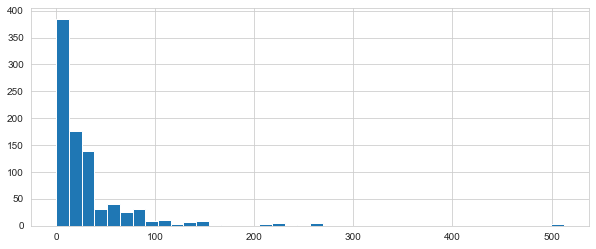

In [11]:
train['Fare'].hist(bins=40,figsize=(10,4))
train.info()

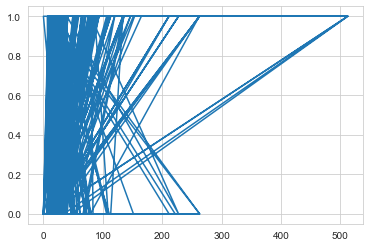

In [12]:
x=train['Fare']
y=train['Survived']
plt.plot(x,y)


# Data Cleaning And Pre-Processing

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

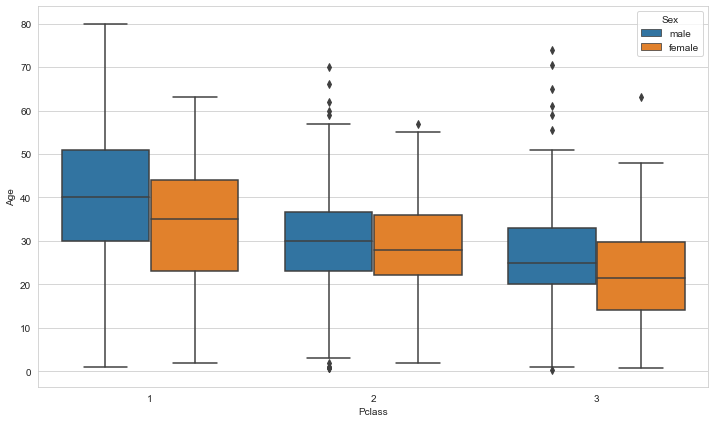

In [13]:
plt.figure(figsize=(12,7))
sns.boxplot(x="Pclass",y="Age",hue="Sex",data=train)

In [14]:
def change_age(cols):
    Age=cols[0]
    Pclass=cols[1]
    Sex=cols[2]
    
    if pd.isnull(Age):
        if Pclass==1:
            if Sex=='Female':
                return 35
            else:
                return 40
        elif Pclass==2:
            if Sex=='Female':
                return 30
            else:
                return 28
        else:
            if Sex=='Female':
                return 24
            else:
                return 21 
    else:
        return Age

def compute_age(cols):
    age=cols[0]
    if age<=16:
        return 0
    if (age>16) & (age<=32):
        return 1
    if (age>32) & (age<=48):
        return 2
    if (age>48) & (age<=64):
        return 3
    return 4

def compute_fare(cols):
    fare=cols[0]
    if fare<=17:
        return 0
    if (fare>17) & (fare<=30):
        return 1
    if (fare>30) & (fare<=100):
        return 2
    return 3

# train['New_Fare'] = train[['Fare']].apply(compute_fare, axis=1)
    
def change_name(cols):
    Name=cols[0]
    
    if "Mr." in Name:
        return 0
    if "Mrs." in Name:
        return 1
    if "Miss." in Name:
        return 2
    return 3

In [15]:
train['Age'] = train[['Age','Pclass','Sex']].apply(change_age,axis=1)
train['NewAge'] = train[['Age']].apply(compute_age, axis=1)

train['NewFare'] = train[['Fare']].apply(compute_fare, axis=1)

train['NewFeature'] = train[['Name']].apply(change_name, axis=1).astype(np.int32)

train.drop('Cabin',axis=1,inplace=True)

# train["FamilySize"] = train["SibSp"] + train["Parch"] + 1

sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

train.drop(['Sex','Embarked','Name','Ticket','Age','Fare'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)

train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,NewAge,NewFare,NewFeature,male,Q,S
0,1,0,3,1,0,1,0,0,1,0,1
1,2,1,1,1,0,2,2,1,0,0,0
2,3,1,3,0,0,1,0,2,0,0,1
3,4,1,1,1,0,2,2,1,0,0,1
4,5,0,3,0,0,2,0,0,1,0,1


# Classifier

In [16]:
from sklearn.model_selection import train_test_split
X_train = train.drop('Survived',axis=1)
X_train = X_train.drop('PassengerId',axis=1)
y_train = train['Survived']

# Random Forest Classifier 

In [17]:
#Number of trees in Random Forest
n_estimators=[50,100,400,700,1000] #[int(x) for x in np.linspace(start=10,stop=510,num=10)]
#Number of features to consider at every split
max_features=['auto']
#Maximum number of levels in a tree
max_depth=[2,3, 4, 5]
#Minimum number of samples required to split a node 
min_samples_split=[2,4,10,12,16]
#Minimum number of samples required at each leaf node
min_samples_leaf=[1,5,10]
#Method of selecting samples for training each tree
bootstrap=[True, False]

In [18]:
#Create the parameter grid
random_grid={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf,
            'bootstrap':bootstrap}

In [19]:
rf_model=RandomForestClassifier()

In [20]:
from sklearn.model_selection import GridSearchCV
rf_grid=GridSearchCV(estimator=rf_model,param_grid=random_grid,cv=3,n_jobs=-1)


In [ ]:
rf_grid.fit(X_train,y_train)


In [ ]:
rf_grid.best_params_

# Reading the test data 

In [ ]:
predictions = rf_grid.predict(test) 

In [ ]:
# from sklearn.metrics import classification_report

# print(classification_report(y_test,predictions))

In [ ]:
test=pd.read_csv('Datasets\\test.csv')
test2=pd.read_csv('Datasets\\test.csv')
test.head()

In [ ]:
test['Age'] = test[['Age','Pclass','Sex']].apply(change_age,axis=1)

test['NewAge'] = test[['Age']].apply(compute_age, axis=1)

test['NewFeature'] = test[['Name']].apply(change_name, axis=1).astype(np.int32)

test.drop('Cabin',axis=1,inplace=True)

test.drop('PassengerId',axis=1,inplace=True)

# test["FamilySize"] = test["SibSp"] + test["Parch"] + 1
test['NewFare'] = test[['Fare']].apply(compute_fare, axis=1)

test['Fare'] = test['Fare'].replace(np.nan, 0)

sex = pd.get_dummies(test['Sex'],drop_first=True)
embark = pd.get_dummies(test['Embarked'],drop_first=True)

test.drop(['Sex','Embarked','Name','Ticket','Age','Fare'],axis=1,inplace=True)
test = pd.concat([test,sex,embark],axis=1)
test.fillna(0)
test.head()




In [ ]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')


In [ ]:
rf_model=RandomForestClassifier(bootstrap=False, max_depth= 4,max_features= 'auto', min_samples_leaf= 1, min_samples_split= 4,n_estimators= 250)

In [ ]:
X_train = train.drop('Survived',axis=1)
X_train = X_train.drop('PassengerId',axis=1)
y_train = train['Survived']

rf_model.fit(X_train, y_train)

In [ ]:
predictions2=rf_model.predict(test)

test_out = pd.DataFrame({'PassengerId': test2['PassengerId'] , 'Survived': predictions2})
test_out.to_csv('test_out_cv.csv')

# K Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(X_train,y_train)

In [ ]:
pred = knn.predict(test)

In [ ]:
test_out3 = pd.DataFrame({'PassengerId': test2['PassengerId'] , 'Survived': predictions2})

In [ ]:
test_out3.to_csv('test_out3.csv')

Achieved an accuracy of 78.229 on the test set.

# Random Forest

In [ ]:
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rfc.fit(X_train, y_train)

In [ ]:
rfc_pred = rfc.predict(test)

In [ ]:
test_out4 = pd.DataFrame({'PassengerId': test2['PassengerId'] , 'Survived': rfc_pred})

In [ ]:
test_out4.to_csv('test_out4.csv')

Achieved an accuracy of 77.751 on the test set 

# Logistic Regression 

In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

In [80]:
lmodel_predict = logmodel.predict(test) 

In [81]:
test_out5 = pd.DataFrame({'PassengerId': test2['PassengerId'] , 'Survived': lmodel_predict})

In [82]:
test_out5.to_csv('test_out5.csv')

Achieved an accuracy of 75 on the test set 